In [1]:
import supereeg as se
import numpy as np
from scipy.spatial.distance import cdist
from scipy.special import logsumexp
import seaborn as sns
%matplotlib inline

In [2]:

def z2r(z):

    return (np.exp(2 * z) - 1) / (np.exp(2 * z) + 1)

def r2z(r):

    return 0.5 * (np.log(1 + r) - np.log(1 - r))

def _to_log_complex(X):

    signX = np.sign(X)
    posX = np.log(np.multiply(signX > 0, X))
    negX = np.log(np.abs(np.multiply(signX < 0, X)))

    negX = np.multiply(0+1j, negX)
    negX.real[np.isnan(negX)] = 0

    return posX + negX

def _to_exp_real(C):

    posX = C.real
    negX = C.imag
    return np.exp(posX) - np.exp(negX)

def _set_numerator(n_real, n_imag):

    numerator = np.zeros_like(n_real, dtype=np.complex128)
    numerator.real = n_real
    numerator.imag = n_imag

def _recover_model(num, denom, z_transform=False):

    m = np.divide(_to_exp_real(num), np.exp(denom)) #numerator and denominator are in log units
    if z_transform:
        np.fill_diagonal(m, np.inf)
        return m
    else:
        np.fill_diagonal(m, 1)
        return z2r(m)


In [3]:
a = np.array([[1,2,3],[4,5,6],[7,8,9,]])
b = np.array([[-1,2,2],[-4,5,5],[-7,8,8,]])
c = np.array([[ 0,  4,  5], [ 0, 10, 11],[ 0, 16, 17]])

## check a + b == c

In [4]:
add_log = _to_log_complex(a)

a_log = _to_log_complex(a)
b_log = _to_log_complex(b)
c_log = _to_log_complex(c)

add_log.real = np.logaddexp(a_log.real,b_log.real)
add_log.imag = np.logaddexp(a_log.imag,b_log.imag)

try_add = _to_exp_real(add_log)

np.allclose(try_add, c)

/Library/Python/2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in log
/Library/Python/2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in multiply
/Library/Python/2.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: divide by zero encountered in log


True

## check c - a = b

In [5]:
sub_log = _to_log_complex(a)

## multiply a by -1 
neg_a_log = _to_log_complex(-a)

sub_log.real = np.logaddexp(c_log.real, neg_a_log.real)
sub_log.imag = np.logaddexp(c_log.imag, neg_a_log.imag)

b_try = _to_exp_real(sub_log)
np.allclose(b_try, b)

/Library/Python/2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in log
/Library/Python/2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in multiply
/Library/Python/2.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: divide by zero encountered in log


True

## make it into a function

In [6]:
def _logsubexp(x,y):
    """
    Subtracts logged arrays
    Parameters
    ----------
    x : Numpy array
        Log complex array
    y : Numpy array
        Log complex array
    Returns
    ----------
    z : Numpy array
        Returns log complex array of x-y
    """
    y = _to_exp_real(y)
    sub_log = _to_log_complex(x)
    neg_y_log = _to_log_complex(-y)
    sub_log.real = np.logaddexp(x.real, neg_y_log.real)
    sub_log.imag = np.logaddexp(x.imag, neg_y_log.imag)
    return sub_log

In [7]:
try_it = _to_exp_real(_logsubexp(c_log,a_log))

/Library/Python/2.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in multiply
/Library/Python/2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in multiply
/Library/Python/2.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: divide by zero encountered in log


In [8]:
np.allclose(try_it,b)

True

# Now try to update the functions in model.py

### The expand_corrmat_predict function calculates only the expanded locations by looping over the upper triangle of the remaining locations and storing the indices as 'sliced_up'.  This then allows us to parrallelize the compute_coord function for each set of index values.  The compute_coord function is essentially the inner loop of the original nested for loop function (calculating the sum of the weights and the sum of the weighted correlation values).  

In [9]:
## with log weights 
## compute in log space
def _compute_coord(coord, weights, Z):
    next_weights = np.add.outer(weights[coord[0], :], weights[coord[1], :])

    next_weights = _logsubexp(next_weights, np.triu(next_weights))

    return logsumexp(next_weights), logsumexp(Z + next_weights)



## rather than exponentiating 
def _compute_coord_old(coord, weights, Z):
    exp_weights = np.exp(weights)
    next_weights = np.outer(exp_weights[coord[0], :], exp_weights[coord[1], :])
    next_weights = next_weights - np.triu(next_weights) 
    return np.sum(next_weights), np.sum(Z * next_weights)



def _log_rbf(to_coords, from_coords, width=20):

    assert np.isscalar(width), 'RBF width must be a scalar'
    assert width > 0, 'RBF width must be positive'
    weights = -cdist(to_coords, from_coords, metric='euclidean') ** 2 / float(width)
    return weights

## Define some sample locations, and subsample

In [10]:
locs = np.array([[-61., -77.,  -3.],
                 [-41., -77., -23.],
                 [-21., -97.,  17.],
                 [-21., -37.,  77.],
                 [-21.,  63.,  -3.],
                 [ -1., -37.,  37.],
                 [ -1.,  23.,  17.],
                 [ 19., -57., -23.],
                 [ 19.,  23.,  -3.],
                 [ 39., -57.,  17.],
                 [ 39.,   3.,  37.],
                 [ 59., -17.,  17.]])

sub_locs = locs[6:]

## Get log weights from these locations

In [11]:
weights = _log_rbf(sub_locs, locs, width=20)

## Make up a full correlation matrix 

In [12]:
Z = r2z(se.create_cov(cov='random', n_elecs=np.shape(locs)[0]))

/Library/Python/2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log


## Define an example coord

In [13]:
coord = tuple((3, 0))


## these 
try_old = _compute_coord_old(coord, weights, Z)
try_new = _to_exp_real(np.asarray(_compute_coord(coord, weights, Z)))

/Library/Python/2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in multiply
/Library/Python/2.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: divide by zero encountered in log
/Library/Python/2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in log
/Library/Python/2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in multiply


## these should be the same I beleive, but they arent

In [14]:
try_old

(1.0, nan)

In [15]:
try_new

array([78., inf])

## Comparing line by line

In [16]:
next_weights_log = np.add.outer(weights[coord[0], :], weights[coord[1], :])

In [17]:
try_1_new = np.exp(next_weights_log)

In [18]:
exp_weights = np.exp(weights)

In [19]:
try_1_old = np.outer(exp_weights[coord[0], :], exp_weights[coord[1], :])

### Adding outer product with logs same as taking outer product with the exponentiated weights

In [20]:
np.allclose(try_1_old, try_1_new)

True

In [31]:
upper_tri = next_weights_log
### should I replace the 0s with infs?? ## fill in with neg infs
upper_tri[np.tril_indices(upper_tri.shape[0], -1)] = np.inf
subtract_log = _logsubexp(next_weights_log, upper_tri)

#subtract_log =_logsubexp(next_weights_log, np.triu(next_weights_log))


/Library/Python/2.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: divide by zero encountered in log
/Library/Python/2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in multiply
/Library/Python/2.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in multiply
/Library/Python/2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in log
/Library/Python/2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in multiply


In [32]:
upper_tri

array([[-1240., -1200., -1280.,  -920.,  -660.,  -740.,  -540.,  -960.,
         -580.,  -940.,  -660.,  -800.],
       [   inf, -1080., -1160.,  -800.,  -540.,  -620.,  -420.,  -840.,
         -460.,  -820.,  -540.,  -680.],
       [   inf,    inf, -1000.,  -640.,  -380.,  -460.,  -260.,  -680.,
         -300.,  -660.,  -380.,  -520.],
       [   inf,    inf,    inf,  -760.,  -500.,  -580.,  -380.,  -800.,
         -420.,  -780.,  -500.,  -640.],
       [   inf,    inf,    inf,    inf, -1040., -1120.,  -920., -1340.,
         -960., -1320., -1040., -1180.],
       [   inf,    inf,    inf,    inf,    inf,  -320.,  -120.,  -540.,
         -160.,  -520.,  -240.,  -380.],
       [   inf,    inf,    inf,    inf,    inf,    inf,  -400.,  -820.,
         -440.,  -800.,  -520.,  -660.],
       [   inf,    inf,    inf,    inf,    inf,    inf,    inf,  -520.,
         -140.,  -500.,  -220.,  -360.],
       [   inf,    inf,    inf,    inf,    inf,    inf,    inf,    inf,
         -400.,  -760., 

In [33]:
subtract_log

array([[0.00000000e+000 +0.j, 0.00000000e+000 +0.j, 0.00000000e+000 +0.j,
        0.00000000e+000 +0.j, 2.32082259e-287 +0.j, 4.19955799e-322 +0.j,
        3.02677245e-235 +0.j, 0.00000000e+000 +0.j, 1.28588016e-252 +0.j,
        0.00000000e+000 +0.j, 2.32082259e-287 +0.j, 0.00000000e+000 +0.j],
       [            nan+infj, 0.00000000e+000 +0.j, 0.00000000e+000 +0.j,
        0.00000000e+000 +0.j, 3.02677245e-235 +0.j, 5.46287446e-270 +0.j,
        3.94745875e-183 +0.j, 0.00000000e+000 +0.j, 1.67702032e-200 +0.j,
        0.00000000e+000 +0.j, 3.02677245e-235 +0.j, 4.78357190e-296 +0.j],
       [            nan+infj,             nan+infj, 0.00000000e+000 +0.j,
        1.12598235e-278 +0.j, 9.29173632e-166 +0.j, 1.67702032e-200 +0.j,
        1.21181048e-113 +0.j, 4.78357190e-296 +0.j, 5.14820022e-131 +0.j,
        2.32082259e-287 +0.j, 9.29173632e-166 +0.j, 1.46848465e-226 +0.j],
       [            nan+infj,             nan+infj,             nan+infj,
        0.00000000e+000 +0.j, 7.124

In [34]:
_to_exp_real(subtract_log)

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [nan,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [nan, nan,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [nan, nan, nan,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [nan, nan, nan, nan,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [nan, nan, nan, nan, nan,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [nan, nan, nan, nan, nan, nan,  0.,  0.,  0.,  0.,  0.,  0.],
       [nan, nan, nan, nan, nan, nan, nan,  0.,  0.,  0.,  0.,  0.],
       [nan, nan, nan, nan, nan, nan, nan, nan,  0.,  0.,  0.,  0.],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan,  0.,  0.,  0.],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,  0.,  0.],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,  0.]])

In [35]:
subtract_exp = try_1_old - np.triu(try_1_old)

In [36]:
subtract_exp

array([[0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 0.00000000

In [37]:
np.allclose(subtract_exp, _to_exp_real(subtract_log))

False

## I think the issue is with subtracting... should the other

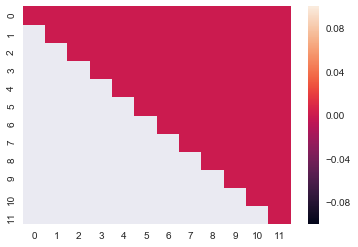

In [38]:
sns.heatmap(_to_exp_real(subtract_log))

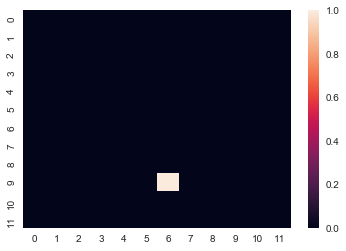

In [39]:
sns.heatmap(subtract_exp)

In [40]:
sns.heatmap(try_sub)

NameError: name 'try_sub' is not defined

In [ ]:
sns.heatmap(np.triu(try_2))

In [ ]:
try_sub

In [ ]:
sns.heatmap(next_weights_log)

next_weights_log[np.tril_indices(next_weights_log.shape[0], -1)] = np.inf
next_weights_log

In [ ]:
np.log(np.triu(next_weights))

In [ ]:
wtf = _logsubexp(next_weights_log, np.triu(next_weights_log))

In [ ]:
sns.heatmap(_to_exp_real(wtf))

In [ ]:
np.allclose(np.exp(wtf), try_sub)